In [1]:
import pickle
import glob
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.model_selection import train_test_split

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
tf.random.set_seed(1)

In [3]:
with open('frames/mean_speeds', 'rb') as f:
    speeds = pickle.load(f)

In [4]:
c = Counter()
c.update([int(s) for s in speeds])

Text(0.5, 1.0, 'Frequency of Speeds')

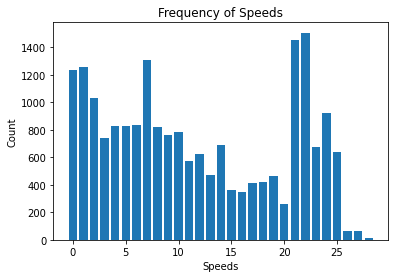

In [5]:
plt.bar(c.keys(), c.values())
plt.xlabel("Speeds")
plt.ylabel("Count")
plt.title("Frequency of Speeds")

In [6]:
IMG_SIZE = 224

In [7]:
basemodel = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),include_top=False,
                                               weights='imagenet')

In [8]:
basemodel.trainable = False

In [9]:
basemodel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [10]:
images = sorted(glob.glob('frames/unthreaded_flow/*.jpg'))
len(images)

20399

In [11]:
x_train, x_test, y_train, y_test = train_test_split(
...     images, speeds, test_size=0.33, random_state=42)

In [12]:
img = images[:3]
s = speeds[:3]
img

['frames/unthreaded_flow/flow_0.jpg',
 'frames/unthreaded_flow/flow_1.jpg',
 'frames/unthreaded_flow/flow_10.jpg']

(480, 640, 3)


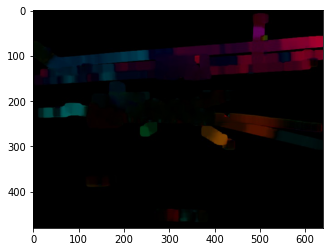

In [13]:
i = plt.imread(img[0])
print(i.shape)
plt.imshow(i)

In [14]:
def format_example(image, speed):
    image_string = tf.io.read_file(image)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE,))
    return image, speed

In [15]:
BATCH_SIZE = 32

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(format_example)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(format_example)
test_dataset = test_dataset.batch(BATCH_SIZE)

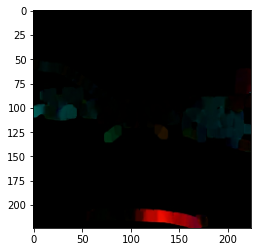

In [18]:
for i, stt in train_dataset.take(1):
    plt.imshow((i[0]+1)*.5)

In [19]:
feature_batch = basemodel(i)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [20]:
conv_layer = tf.keras.layers.Conv2D(1280, (2,2))
output = conv_layer(feature_batch)
print(output.shape)

(32, 6, 6, 1280)


In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [22]:
dense = tf.keras.layers.Dense(1024, activation='relu')
d = dense(feature_batch_average)
print(d.shape)

(32, 1024)


In [23]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(d)
print(prediction_batch.shape)

(32, 1)


In [24]:
model = tf.keras.Sequential([
  basemodel,
  conv_layer,
  global_average_layer,
  dense,
  prediction_layer
])

In [95]:
base_learning_rate = 3e-4
logdir = "logs/"

model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='mse',
              metrics=['mae'])

In [96]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 1280)        6554880   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 1025      
Total params: 10,125,633
Trainable params: 7,867,649
Non-trainable params: 2,257,984
_________________________________________________________________


In [98]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

history = model.fit(dataset, epochs=20,
                    validation_split=.3,
                   callbacks=[stopping, tensorboard_callback])

ValueError: `validation_split` is only supported for Tensors or NumPy arrays, found: (<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.float64)>, None, None)

In [67]:
%load_ext tensorboard
%tensorboard --logdir logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 13169), started 18:44:34 ago. (Use '!kill 13169' to kill it.)

In [68]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # summarize output shape
    print(i, layer.name, layer.output.shape)

1 conv2d_1 (None, 6, 6, 1280)


In [70]:
feature_extractor = tf.keras.Sequential([
    basemodel,
  conv_layer]
)

In [71]:
for test, _ in dataset.take(1):
    pass

In [73]:
features = feature_extractor(test)

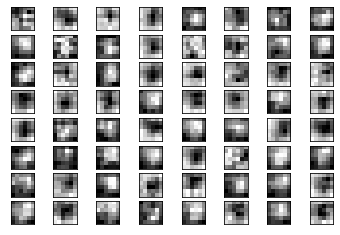

In [77]:
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(features[0, :, :, ix-1], cmap='gray')
        ix += 1

In [80]:
tf.keras.utils.plot_model(model)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


['frames/unthreaded_flow/flow_0.jpg',
 'frames/unthreaded_flow/flow_1.jpg',
 'frames/unthreaded_flow/flow_10.jpg']